In [135]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [109]:
ties_df = pd.read_excel("TIESv4-1.xls")
cow_df = pd.read_csv("COW-country-codes.csv")
plty_df = pd.read_excel("POLITY5-PRC.xlsx")

In [110]:
# Identify columns that are years
year_columns = [col for col in plty_df.columns if col.isdigit()]

# Melt the entire Polity dataset (no filtering by Indicator)
melted_df_auto = plty_df.melt(
    id_vars=['Economy Name', 'Indicator'], 
    value_vars=year_columns, 
    var_name='Year', 
    value_name='Value'
)

# Convert Year and Value to numeric and drop missing
melted_df_auto['Year'] = pd.to_numeric(melted_df_auto['Year'], errors='coerce')
melted_df_auto = melted_df_auto.dropna(subset=['Year'])
melted_df_auto['Year'] = melted_df_auto['Year'].astype(int)

melted_df_auto['Value'] = pd.to_numeric(melted_df_auto['Value'], errors='coerce')
melted_df_auto = melted_df_auto.dropna(subset=['Value'])

# Standardize country names
def safe_upper_strip(x):
    if isinstance(x, str):
        return x.upper().strip()
    return np.nan

melted_df_auto['Economy_Name_standardized'] = melted_df_auto['Economy Name'].apply(safe_upper_strip)
cow_df['StateNme_standardized'] = cow_df['StateNme'].apply(safe_upper_strip)

melted_df_auto = melted_df_auto.dropna(subset=['Economy_Name_standardized'])
cow_df = cow_df.dropna(subset=['StateNme_standardized'])

# Map countries to their CCode
country_mapping = dict(zip(cow_df['StateNme_standardized'], cow_df['CCode']))
melted_df_auto['Country_Code'] = melted_df_auto['Economy_Name_standardized'].map(country_mapping)
melted_df_auto = melted_df_auto.dropna(subset=['Country_Code'])
melted_df_auto['Country_Code'] = melted_df_auto['Country_Code'].astype(int)

melted_df_auto = melted_df_auto[~(
    (melted_df_auto['Indicator'] == 'Polity database: Combined Polity Score') &
    ((melted_df_auto['Value'] < -10) | (melted_df_auto['Value'] > 10))
)]

# Ensure ties_df has numeric Country_Code and year
ties_df['Country_Code'] = pd.to_numeric(ties_df['targetstate'], errors='coerce')
ties_df = ties_df.dropna(subset=['Country_Code'])
ties_df['Country_Code'] = ties_df['Country_Code'].astype(int)

ties_df['startyear'] = pd.to_numeric(ties_df['startyear'], errors='coerce')
ties_df = ties_df.dropna(subset=['startyear'])
ties_df['startyear'] = ties_df['startyear'].astype(int)

# Pivot to get a multi-level column structure: columns = Indicator, Year
polity_wide = melted_df_auto.pivot_table(
    index='Country_Code', 
    columns=['Indicator','Year'], 
    values='Value'
)

# Define year offsets
year_offsets = range(-20, 21)

# For each row in ties_df, we extract polity scores for all indicators and all offsets
def get_polity_scores_for_row(row):
    ccode = row['Country_Code']
    event_year = row['startyear']
    if ccode not in polity_wide.index:
        # No polity data for this country
        return [np.nan] * (len(polity_wide.columns.levels[0]) * len(year_offsets))
    
    country_data = polity_wide.loc[ccode]
    all_values = []
    
    # Loop over each indicator
    for indicator in polity_wide.columns.levels[0]:
        # Get just this indicator's time series
        indicator_series = country_data[indicator]
        years_to_extract = [event_year + off for off in year_offsets]
        extracted = indicator_series.reindex(years_to_extract)
        all_values.extend(extracted.values)
    
    return all_values

# Create column names for all indicators and offsets
indicator_names = polity_wide.columns.levels[0]
all_columns = []
for ind in indicator_names:
    for offset in year_offsets:
        all_columns.append(f"{ind}_{offset}")

polity_scores = ties_df.apply(get_polity_scores_for_row, axis=1)
polity_scores_df = pd.DataFrame(polity_scores.tolist(), columns=all_columns, index=ties_df.index)

# Concatenate these columns with the original ties_df
final_df = pd.concat([ties_df, polity_scores_df], axis=1)

In [111]:
final_df = final_df[final_df['startyear'] >= 1960]


In [112]:
#------------------------------------------------------
# Step 1: Create a global year-average dataframe from plty_df
#------------------------------------------------------
# Assuming you have a similar long-format or can create one from plty_df
# For this example, we assume you have or can produce a DataFrame `melted_polity`:
# melted_polity columns: ['Country', 'Year', 'Indicator', 'Value']
# where 'Indicator' matches the component names in `components`.

# If you need to produce it:
# Identify which columns in plty_df represent year columns:
year_cols = [c for c in plty_df.columns if c.isdigit()]

# Melt to long format
melted_polity = plty_df.melt(
    id_vars=['Economy Name','Indicator'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Score'
)

# Convert to numeric
melted_polity['Year'] = pd.to_numeric(melted_polity['Year'], errors='coerce')
melted_polity['Score'] = pd.to_numeric(melted_polity['Score'], errors='coerce')
melted_polity = melted_polity.dropna(subset=['Score','Year'])

# Filter only relevant indicators (components)
comp_polity = melted_polity[melted_polity['Indicator'].isin(plty_df['Indicator'].unique())].copy()

# Compute global yearly average per component
global_yearly = comp_polity.groupby(['Indicator','Year'])['Score'].mean().reset_index()

# Pivot so rows=Year, cols=Indicator, vals=mean Score
global_pivot = global_yearly.pivot(index='Year', columns='Indicator', values='Score')

global_series = pd.Series(data=global_yearly['Score'].values, index=global_yearly['Year'])

### Broad Freq Analysis with Autocracy

Average Polity database: Combined Polity Score (-1 year): 4.5538089480048365


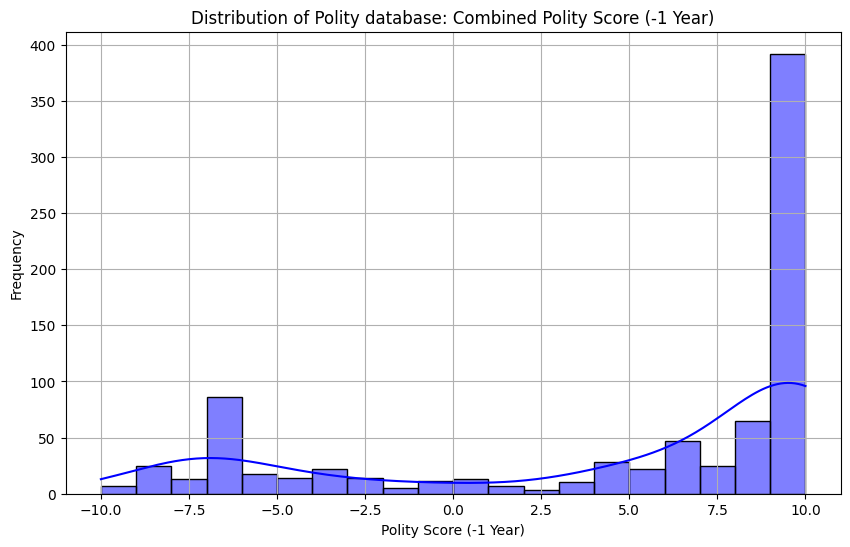

In [113]:
# Make a copy of the final_df before analysis to preserve the original
analysis_df = final_df.copy()

# 1. Calculate the average score at -1 year
mean_score = analysis_df['Polity database: Combined Polity Score_-1'].mean()
print("Average Polity database: Combined Polity Score (-1 year):", mean_score)

# 2. Show the distribution
scores = analysis_df['Polity database: Combined Polity Score_-1'].dropna()

# Make a copy of scores if you plan to do further analysis on it
scores_for_plot = scores.copy()

plt.figure(figsize=(10, 6))
sns.histplot(scores_for_plot, kde=True, bins=20, color='blue')
plt.title("Distribution of Polity database: Combined Polity Score (-1 Year)")
plt.xlabel("Polity Score (-1 Year)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

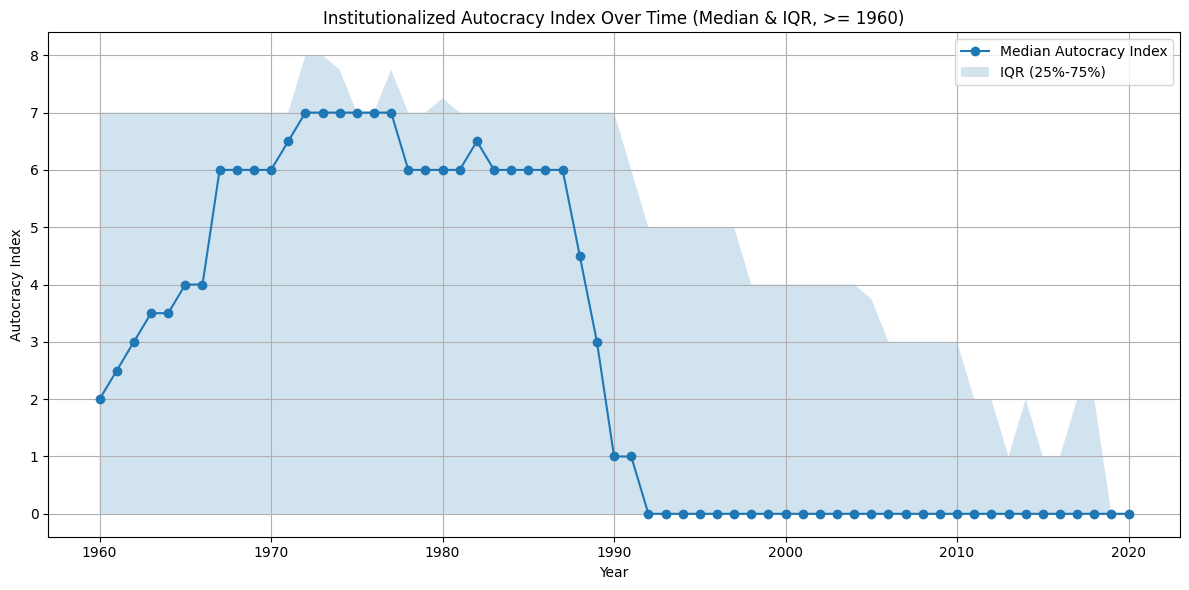

In [114]:
# Make a copy of the original DataFrame
analysis_df = plty_df.copy()

# Filter for the Institutionalized Autocracy Index
autoc_df = analysis_df[analysis_df['Indicator'] == 'Polity database: Institutionalized Autocracy Index']

# Identify year columns
year_columns = [col for col in autoc_df.columns if col.isdigit()]

# Melt into long format
melted_autoc = autoc_df.melt(
    id_vars=['Economy Name', 'Indicator'], 
    value_vars=year_columns, 
    var_name='Year', 
    value_name='AutocracyIndex'
)

# Convert columns to numeric
melted_autoc['Year'] = pd.to_numeric(melted_autoc['Year'], errors='coerce')
melted_autoc['AutocracyIndex'] = pd.to_numeric(melted_autoc['AutocracyIndex'], errors='coerce')
melted_autoc = melted_autoc.dropna(subset=['AutocracyIndex', 'Year'])

# Exclude data before 1970
melted_autoc = melted_autoc[melted_autoc['Year'] >= 1960]

# Group by year and calculate median and IQR
yearly_stats = melted_autoc.groupby('Year')['AutocracyIndex'].agg(median='median')
yearly_stats['Q1'] = melted_autoc.groupby('Year')['AutocracyIndex'].quantile(0.25)
yearly_stats['Q3'] = melted_autoc.groupby('Year')['AutocracyIndex'].quantile(0.75)

# Plot the median line and shading for IQR
plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats['median'], marker='o', label='Median Autocracy Index')
plt.fill_between(yearly_stats.index, yearly_stats['Q1'], yearly_stats['Q3'], alpha=0.2, label='IQR (25%-75%)')

plt.title('Institutionalized Autocracy Index Over Time (Median & IQR, >= 1960)')
plt.xlabel('Year')
plt.ylabel('Autocracy Index')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

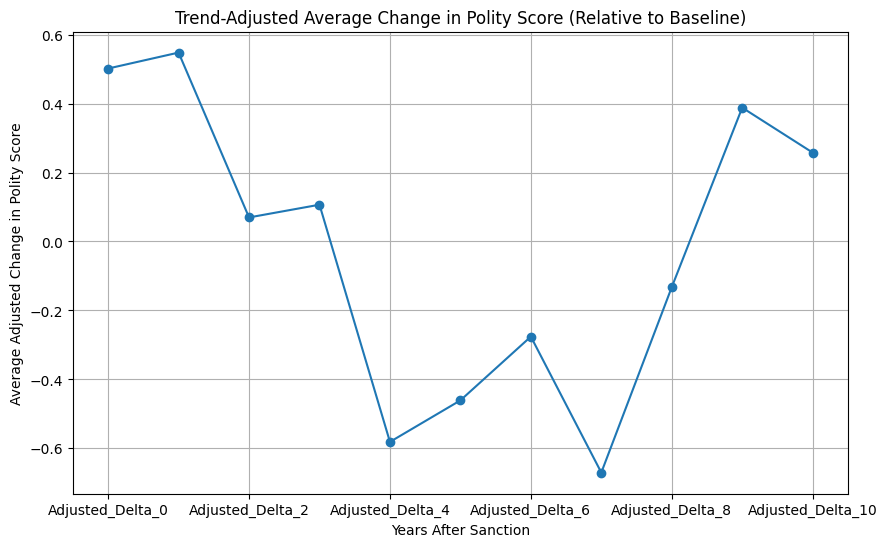

In [115]:
# Parameters
indicator_name = "Polity database: Institutionalized Autocracy Index"
years_post_sanction = range(0, 11)  # From 0 to +10 years after the sanction
baseline_offset = -1

analysis_df = final_df.copy()

# Baseline column
baseline_col = f"{indicator_name}_{baseline_offset}"

# Drop rows without a baseline score
analysis_df = analysis_df.dropna(subset=[baseline_col])

# Ensure we have all needed columns for the offsets we want
required_cols = [baseline_col] + [f"{indicator_name}_{y}" for y in years_post_sanction]
analysis_df = analysis_df.dropna(subset=[c for c in required_cols if c in analysis_df.columns])

#------------------------------------------------------------
# Step 3: Adjust by Global Yearly Means
#------------------------------------------------------------
# For each row (event) and each offset y:
# Actual baseline year = startyear - 1
# Actual offset year = startyear + y
#
# Adjusted score for a given year = (event_score - global_mean_for_that_year)
# Adjusted delta = [ (adjusted_score(startyear+y)) - (adjusted_score(startyear-1)) ]

for y in years_post_sanction:
    current_col = f"{indicator_name}_{y}"
    adjusted_col = f"Adjusted_Delta_{y}"
    
    baseline_years = analysis_df['startyear'] + baseline_offset
    current_years = analysis_df['startyear'] + y
    
    # Get global means aligned with each row
    global_baseline_means = global_pivot[indicator_name].reindex(baseline_years.values).values
    global_current_means = global_pivot[indicator_name].reindex(current_years.values).values
    
    # Raw scores from the event
    baseline_scores = analysis_df[baseline_col].values
    current_scores = analysis_df[current_col].values
    
    # Adjusted delta:
    # = [(current_score - global_current_mean) - (baseline_score - global_baseline_mean)]
    adjusted_delta = (current_scores - global_current_means) - (baseline_scores - global_baseline_means)
    
    analysis_df[adjusted_col] = adjusted_delta

# Identify adjusted delta columns
adjusted_delta_cols = [f"Adjusted_Delta_{y}" for y in years_post_sanction if f"Adjusted_Delta_{y}" in analysis_df.columns]

# Compute the average adjusted deltas
avg_adjusted_deltas = analysis_df[adjusted_delta_cols].mean()

# Plot the trend-controlled changes
plt.figure(figsize=(10,6))
avg_adjusted_deltas.plot(marker='o')
plt.title("Trend-Adjusted Average Change in Polity Score (Relative to Baseline)")
plt.xlabel("Years After Sanction")
plt.ylabel("Average Adjusted Change in Polity Score")
plt.grid(True)
plt.show()

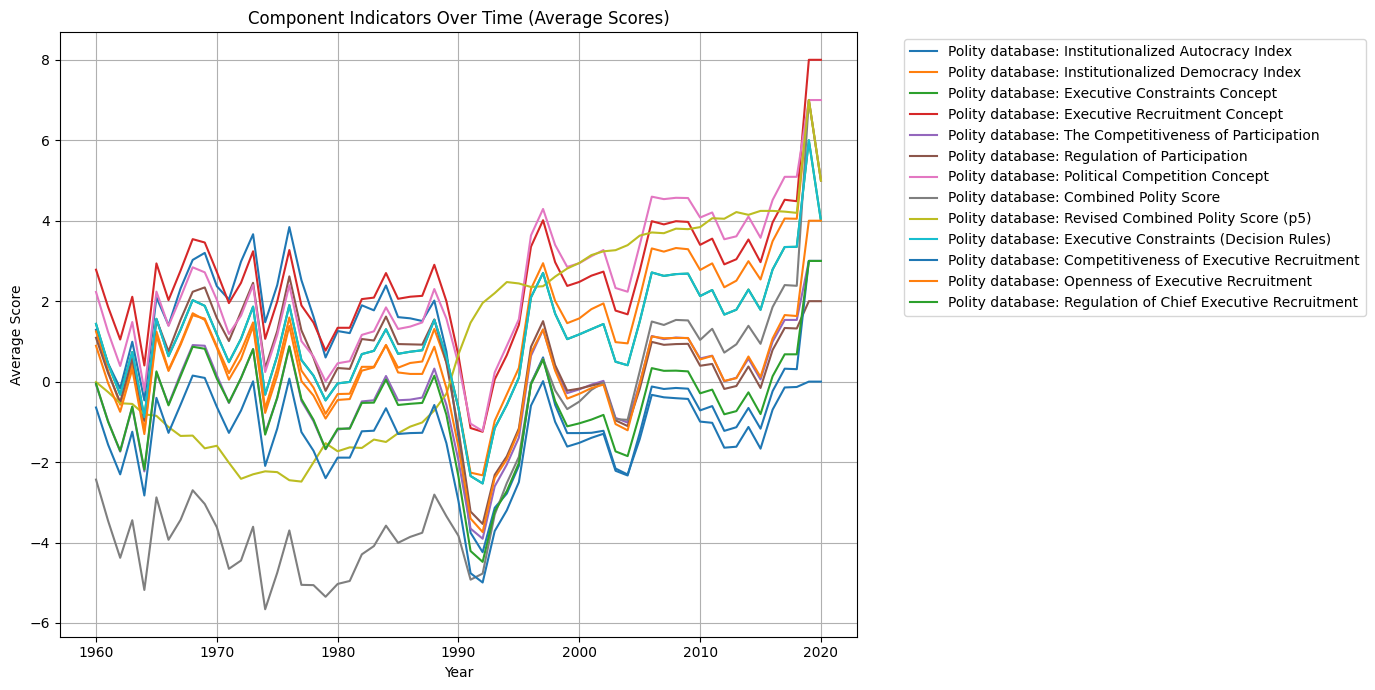

In [116]:
components_of_interest = ['Polity database: Institutionalized Autocracy Index',
       'Polity database: Institutionalized Democracy Index',
       'Polity database: Executive Constraints Concept',
       'Polity database: Executive Recruitment Concept',
       'Polity database: The Competitiveness of Participation',
       'Polity database: Regulation of Participation',
       'Polity database: Political Competition Concept',
       'Polity database: Combined Polity Score',
       'Polity database: Revised Combined Polity Score (p5)',
       'Polity database: Executive Constraints (Decision Rules)',
       'Polity database: Competitiveness of Executive Recruitment',
       'Polity database: Openness of Executive Recruitment',
       'Polity database: Regulation of Chief Executive Recruitment']
comp_df = plty_df[plty_df['Indicator'].isin(components_of_interest)].copy()
# Identify year columns (assuming same format as before)
year_columns = [col for col in comp_df.columns if col.isdigit()]

# Melt into long format: Economy Name, Indicator, Year, Value
melted_comp = comp_df.melt(
    id_vars=['Economy Name', 'Indicator'],
    value_vars=year_columns,
    var_name='Year',
    value_name='Score'
)

# Convert types
melted_comp['Year'] = pd.to_numeric(melted_comp['Year'], errors='coerce')
melted_comp['Score'] = pd.to_numeric(melted_comp['Score'], errors='coerce')

melted_comp = melted_comp.dropna(subset=['Score', 'Year'])

# Optional: Filter for time period (e.g., >= 1970)
melted_comp = melted_comp[melted_comp['Year'] >= 1960]

# Compute annual averages for each component
annual_components = melted_comp.groupby(['Indicator','Year'])['Score'].mean().reset_index()

# Pivot so each component is a column; rows = Year
annual_pivot = annual_components.pivot(index='Year', columns='Indicator', values='Score')

# Now 'annual_pivot' has a row per year and a column per each component indicator
# You can plot trends of components over time:
plt.figure(figsize=(14,7))
for indicator in components_of_interest:
    if indicator in annual_pivot.columns:
        plt.plot(annual_pivot.index, annual_pivot[indicator], label=indicator)

plt.title("Component Indicators Over Time (Average Scores)")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

Trend-Adjusted Average 10-Year Impact on Polity Components:
    Polity database: Institutionalized Autocracy Index  \
0                                           -0.916023    
1                                           -2.607814    
2                                           -4.035416    
3                                           -3.222296    
4                                           -4.556021    
5                                           -3.589903    
6                                           -3.727796    
7                                           -5.524590    
8                                           -3.823994    
9                                           -3.904198    
10                                          -5.377050    

    Polity database: Institutionalized Democracy Index  \
0                                           -0.614076    
1                                           -1.892615    
2                                           -2.994262    
3          

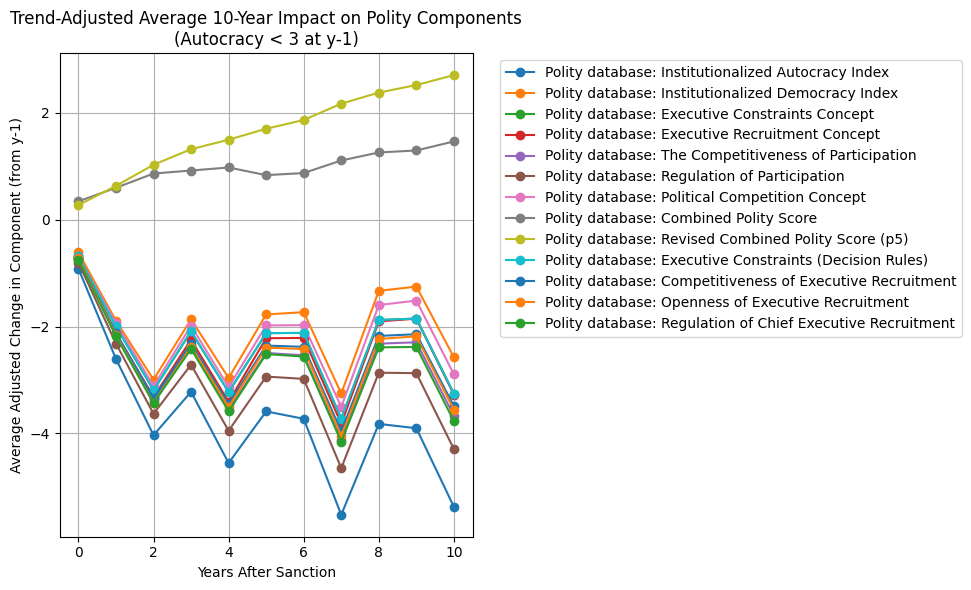

In [117]:
autocracy_threshold = 3
years_post_sanction = range(0, 11)

analysis_df = final_df.copy()

# Filter for autocracy threshold at y-1
analysis_df = analysis_df.dropna(subset=["Polity database: Institutionalized Autocracy Index_-1"])
analysis_df = analysis_df[analysis_df["Polity database: Institutionalized Autocracy Index_-1"] > autocracy_threshold]

# We'll store adjusted averages
avg_adjusted_deltas = {}

for comp in components_of_interest:
    required_cols = [f"{comp}_{y}" for y in [-1] + list(years_post_sanction)]
    comp_df = analysis_df.dropna(subset=required_cols).copy()
    
    # Compute raw deltas from baseline (y-1)
    for y in years_post_sanction:
        baseline_col = f"{comp}_-1"
        current_col = f"{comp}_{y}"
        delta_col = f"Delta_{comp}_{y}"
        comp_df[delta_col] = comp_df[current_col] - comp_df[baseline_col]
    
    # Now adjust by global trend:
    # For each event (row), and each y:
    # Find actual year = startyear + y and subtract the global mean delta from that year.
    # Wait, we need to handle global trend properly:
    # The baseline is at startyear-1. For offset y, the actual year is startyear+y.
    # We'll adjust both the baseline and current year's scores by their global means,
    # then recompute the delta. This ensures a proper alignment with global trends.
    
    for y in years_post_sanction:
        baseline_year = comp_df['startyear'] - 1
        current_year = comp_df['startyear'] + y
        
        # Get global baseline mean score for baseline_year and global current mean score for current_year
        # Use .reindex to handle missing years gracefully
        global_baseline_means = global_pivot[comp].reindex(baseline_year.values)
        global_current_means = global_pivot[comp].reindex(current_year.values)
        
        # Adjusted delta = ( (current_score - global_current_mean) - (baseline_score - global_baseline_mean) )
        # We already have current_score and baseline_score in comp_df, let's do it directly:
        baseline_col = f"{comp}_-1"
        current_col = f"{comp}_{y}"
        adjusted_col = f"Adjusted_Delta_{comp}_{y}"
        
        # Convert the global means into arrays aligned with comp_df rows
        comp_df['global_baseline_mean'] = global_baseline_means.values
        comp_df['global_current_mean'] = global_current_means.values
        
        comp_df[adjusted_col] = ( (comp_df[current_col] - comp_df['global_current_mean']) 
                                - (comp_df[baseline_col] - comp_df['global_baseline_mean']) )
    
    # Compute average adjusted deltas across all events
    avg_adjusted_deltas[comp] = [comp_df[f"Adjusted_Delta_{comp}_{y}"].mean() for y in years_post_sanction]

# Create a DataFrame for the adjusted deltas
adjusted_delta_df = pd.DataFrame(avg_adjusted_deltas, index=years_post_sanction)

print("Trend-Adjusted Average 10-Year Impact on Polity Components:")
print(adjusted_delta_df)

# Plot
plt.figure(figsize=(10,6))
for comp in components_of_interest:
    plt.plot(adjusted_delta_df.index, adjusted_delta_df[comp], marker='o', label=comp)

plt.title(f"Trend-Adjusted Average 10-Year Impact on Polity Components\n(Autocracy < {autocracy_threshold} at y-1)")
plt.xlabel("Years After Sanction")
plt.ylabel("Average Adjusted Change in Component (from y-1)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Key here is that overall increases while auto and demo decrease

In [126]:
# Parameters
autocracy_threshold = 3
years_post_sanction = range(0, 11)
baseline_offset = -1

# Choose an outcome variable for the +10 year impact
# Let's pick Institutionalized Autocracy Index as the outcome
dep_indicator = 'Polity database: Institutionalized Autocracy Index'
dep_offset = 10

analysis_df = final_df.copy()

# Baseline columns for all indicators
baseline_cols = [f"{ind}_{baseline_offset}" for ind in components_of_interest]

# We must have the dependent variable columns: baseline and +10 for the chosen dep_indicator
dep_baseline_col = f"{dep_indicator}_{baseline_offset}"
dep_current_col = f"{dep_indicator}_{dep_offset}"

required_cols = baseline_cols + [dep_current_col]

# Filter for autocracy threshold at y-1 using the dep_indicator baseline as a reference
analysis_df = analysis_df.dropna(subset=[dep_baseline_col])
analysis_df = analysis_df[analysis_df[dep_baseline_col] > autocracy_threshold]

# Ensure all required columns exist
for c in required_cols:
    if c not in analysis_df.columns:
        raise ValueError(f"Missing required column: {c}")
        
# Drop rows missing any required columns
analysis_df = analysis_df.dropna(subset=required_cols)

comp_df = analysis_df.copy()

# Compute adjusted deltas for the dependent variable using global trends
# Adjusted delta formula:
# Adjusted_Delta = ( (current_score - global_current_mean) - (baseline_score - global_baseline_mean) )

baseline_years = comp_df['startyear'] + baseline_offset
current_years = comp_df['startyear'] + dep_offset

# Get global baseline and current means for the dependent indicator
global_baseline_means = global_pivot[dep_indicator].reindex(baseline_years.values)
global_current_means = global_pivot[dep_indicator].reindex(current_years.values)

comp_df['global_baseline_mean'] = global_baseline_means.values
comp_df['global_current_mean'] = global_current_means.values

comp_df['Adjusted_Delta_dep'] = ((comp_df[dep_current_col] - comp_df['global_current_mean']) 
                               - (comp_df[dep_baseline_col] - comp_df['global_baseline_mean']))

# Now we have an adjusted 10-year delta for the dependent variable: 'Adjusted_Delta_dep'

# Prepare the predictor variables:
# All indicators at baseline (y-1) will be predictors
X = comp_df[baseline_cols].copy()
y = comp_df['Adjusted_Delta_dep']


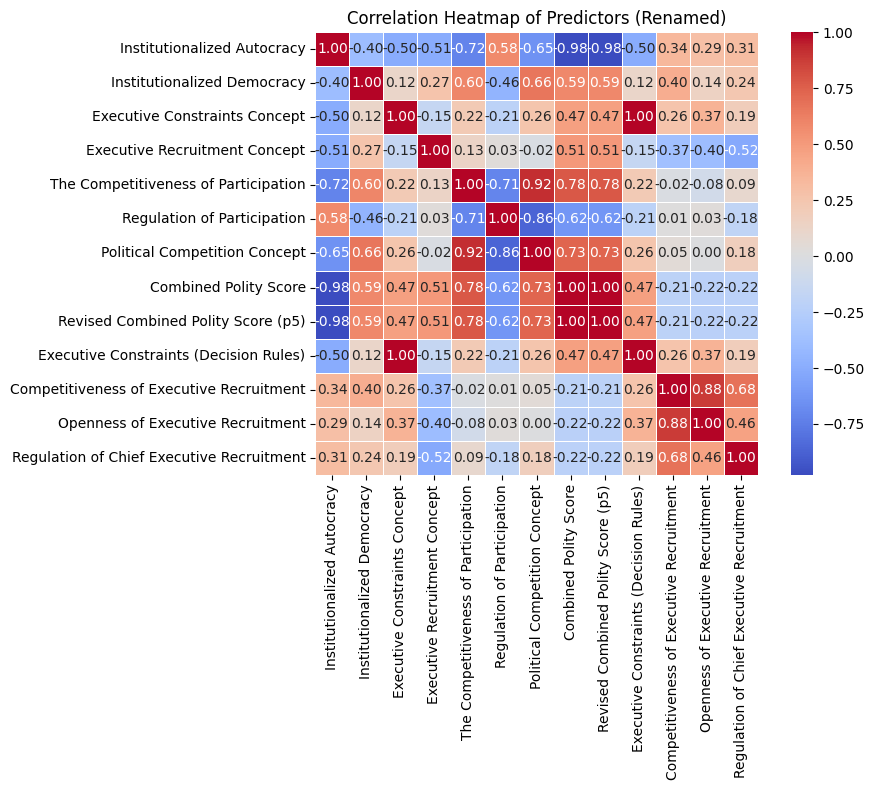

In [134]:
# Define the pattern to extract text after ": " and before " Index" or "_"
pattern = r":\s(.+?)(?:\sIndex|_|$)"

def extract_substring(col_name):
    match = re.search(pattern, col_name)
    if match:
        return match.group(1)
    else:
        return col_name  # If no match, keep original name

# Suppose X is your DataFrame of predictors
# Rename columns according to the pattern
X_renamed = X.copy()
X_renamed.columns = [extract_substring(col) for col in X_renamed.columns]

# Compute the correlation matrix
corr = X_renamed.corr()

# Create a matplotlib figure and axis
plt.figure(figsize=(10, 8))

# Create a heatmap with the renamed columns
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True, linewidths=.5)

plt.title("Correlation Heatmap of Predictors (Renamed)")
plt.tight_layout()
plt.show()

In [136]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                              feature          VIF
0   Polity database: Institutionalized Autocracy I...          inf
1   Polity database: Institutionalized Democracy I...          inf
2   Polity database: Executive Constraints Concept_-1          inf
3   Polity database: Executive Recruitment Concept_-1    43.976885
4   Polity database: The Competitiveness of Partic...   420.727356
5     Polity database: Regulation of Participation_-1  2040.684697
6   Polity database: Political Competition Concept_-1   286.605332
7           Polity database: Combined Polity Score_-1          inf
8   Polity database: Revised Combined Polity Score...          inf
9   Polity database: Executive Constraints (Decisi...          inf
10  Polity database: Competitiveness of Executive ...   274.731438
11  Polity database: Openness of Executive Recruit...    86.744902
12  Polity database: Regulation of Chief Executive...    89.862156


c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [149]:
X = X.loc[:, ~X.columns.str.contains(r"Executive Constraints \(Decision\)|Executive Constraints Concept", case=False)]

X = X.loc[:, ~X.columns.str.contains("Institutionalized Autocracy Index")]

# Drop Regulation of Participation_-1
X = X.loc[:, ~X.columns.str.contains("Regulation of Participation_-1")]

# Drop either The Competitiveness of Participation or Political Competition Concept
# If you choose to keep Political Competition Concept, drop The Competitiveness of Participation:
X = X.loc[:, ~X.columns.str.contains("The Competitiveness of Participation")]

In [150]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                             feature         VIF
0  Polity database: Institutionalized Democracy I...    9.670364
1  Polity database: Executive Recruitment Concept_-1    8.093609
2  Polity database: Political Competition Concept_-1   13.068025
3  Polity database: Executive Constraints (Decisi...    8.889873
4  Polity database: Competitiveness of Executive ...  112.397710
5  Polity database: Openness of Executive Recruit...   52.712777
6  Polity database: Regulation of Chief Executive...   53.152860


In [ ]:
# --------------------------------------------
# Better Time-Series Standardization
# --------------------------------------------
# One possible improvement for time-series standardization:
# Standardize each year's data relative to that year's distribution.
# This means for each feature, subtract the mean and divide by the std dev
# computed only from data in the same startyear.
# This step controls for global shifts over time in the distribution of features.

baseline_cols = [col for col in baseline_cols if col in X.columns]

def time_series_standardize(df, features, group_col='startyear'):
    df = df.copy()
    # Group by year and standardize each feature within that year
    for f in features:
        df[f] = df.groupby(group_col)[f].transform(
            lambda x: (x - x.mean()) / x.std(ddof=0) if x.std(ddof=0) != 0 else x - x.mean()
        )
    return df

# Standardize features year-by-year
X_time_std = time_series_standardize(pd.concat([comp_df['startyear'], X], axis=1), features=baseline_cols, group_col='startyear')
X_time_std = X_time_std[baseline_cols]

# Similarly, you could standardize y year-by-year, although this may not always be desired
# If you want to remove yearly global shifts in the dependent variable as well:
dep_var = 'Adjusted_Delta_dep'  # Define dep_var to match your dependent variable column name

y_time_std = time_series_standardize(
    pd.concat([comp_df['startyear'], y], axis=1),
    features=[dep_var],
    group_col='startyear'
)[dep_var]
# If you prefer global standardization (not year-by-year), use StandardScaler:
# scaler_X = StandardScaler()
# X_std = scaler_X.fit_transform(X)
# scaler_y = StandardScaler()
# y_std = scaler_y.fit_transform(y.values.reshape(-1,1)).ravel()

# For this example, we'll proceed with the time-series standardized values
X_train = X_time_std
y_train = y_time_std

KeyError: 'Column not found: Polity database: Executive Constraints Concept_-1'

Coefficients (time-series standardized):
Polity database: Institutionalized Autocracy Index_-1            1.116630
Polity database: Institutionalized Democracy Index_-1            0.119336
Polity database: Executive Constraints Concept_-1                0.178829
Polity database: Executive Recruitment Concept_-1               -0.346961
Polity database: The Competitiveness of Participation_-1         0.146542
Polity database: Regulation of Participation_-1                  0.178702
Polity database: Political Competition Concept_-1               -0.316488
Polity database: Combined Polity Score_-1                        0.566469
Polity database: Revised Combined Polity Score (p5)_-1           0.566469
Polity database: Executive Constraints (Decision Rules)_-1       0.178829
Polity database: Competitiveness of Executive Recruitment_-1    -0.163833
Polity database: Openness of Executive Recruitment_-1           -0.112088
Polity database: Regulation of Chief Executive Recruitment_-1   -0.1681

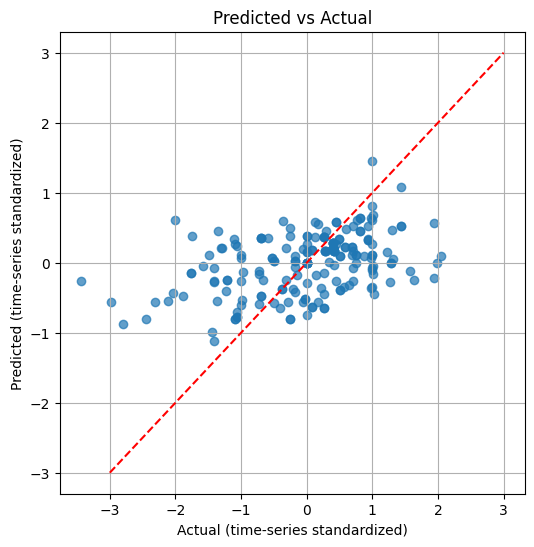

In [129]:
# --------------------------------------------
# Fit model using scikit-learn LinearRegression
# --------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# Check coefficients
coefs = pd.Series(model.coef_, index=baseline_cols)
print("Coefficients (time-series standardized):")
print(coefs)
print("Intercept:", model.intercept_)

# If you want to evaluate predictions:
y_pred = model.predict(X_train)

# Evaluate model performance (e.g., R^2)
r2 = model.score(X_train, y_train)
print("R-squared:", r2)

# Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_pred, alpha=0.7)
plt.plot([-3,3],[-3,3], 'r--')  # if standardized, y should roughly be in a similar scale
plt.xlabel("Actual (time-series standardized)")
plt.ylabel("Predicted (time-series standardized)")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

# Interpretation:
# - This code applies a year-by-year standardization that accounts for time-series structure.
# - The LinearRegression model fits the standardized predictors to the standardized dependent variable.
# - The coefficients and R² help understand how baseline conditions relate to the adjusted outcome after controlling for year-specific distributions.

In [132]:
# Add a constant term for OLS
X_train_const = sm.add_constant(X_train)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_const)
ols_results = ols_model.fit()

# Print summary to see coefficients, p-values, t-stats, and significance levels
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:     Adjusted_Delta_dep   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     3.857
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           4.97e-05
Time:                        07:53:53   Log-Likelihood:                -258.14
No. Observations:                 201   AIC:                             540.3
Df Residuals:                     189   BIC:                             579.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------